# **Group 4 ADS508 Final Project**

Monitoring Water Quality | Released by Tech-AAB

Team: Parisa Kamizi, Landon Padgett, Vicky van der Wagt

-----------------------------------------------------------------------

# Import required libraries

In [2]:
import pandas as pd
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import boto3
import sagemaker
import warnings
from sklearn.preprocessing import LabelEncoder
from io import StringIO
!pip install --disable-pip-version-check -q PyAthena==2.1.0
import numpy as np
from pyathena import connect
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from io import StringIO
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, recall_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import geopandas as gpd
from shapely.geometry import Point
import folium


warnings.filterwarnings("ignore")

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


# Extract Data

**Download data from s3 into the "data" folder"**

*Commented out because it only needs to be done once*

In [5]:
#!aws s3 cp 's3://ads508group4finalproject/stations.csv' ./data/
#!aws s3 cp 's3://ads508group4finalproject/field_results.csv' ./data/
#!aws s3 cp 's3://ads508group4finalproject/lab_results.csv' ./data/
#!aws s3 cp 's3://ads508group4finalproject/period_of_record.csv' ./data/

download: s3://ads508group4finalproject/field_results.csv to data/field_results.csv


In [6]:
st = pd.read_csv("./data/stations.csv")
fr = pd.read_csv("./data/field_results.csv")
lr = pd.read_csv("./data/lab_results.csv")
por = pd.read_csv("./data/period_of_record.csv")

# Initial Data Exploration

**Compare df # of rows and columns**

In [7]:
#generate dictionary
df_data = {
    'df': ['st', 'por', 'fr', 'lr'],
    'df longname': ['Stations', 'Period of Record', 'Field Results', 'Lab Results'],
    '# of Rows': [st.shape[0], por.shape[0], fr.shape[0], lr.shape[0]],
    '# of Columns': [st.shape[1], por.shape[1], fr.shape[1], lr.shape[1]]
}

#convert dictionary into dataframe
df_info = pd.DataFrame(df_data)

#print dataframe
print(tabulate(df_info, headers='keys', tablefmt='fancy_grid'))


╒════╤══════╤══════════════════╤═════════════╤════════════════╕
│    │ df   │ df longname      │   # of Rows │   # of Columns │
╞════╪══════╪══════════════════╪═════════════╪════════════════╡
│  0 │ st   │ Stations         │       44475 │             11 │
├────┼──────┼──────────────────┼─────────────┼────────────────┤
│  1 │ por  │ Period of Record │      733915 │             12 │
├────┼──────┼──────────────────┼─────────────┼────────────────┤
│  2 │ fr   │ Field Results    │     1199457 │             22 │
├────┼──────┼──────────────────┼─────────────┼────────────────┤
│  3 │ lr   │ Lab Results      │     4610840 │             18 │
╘════╧══════╧══════════════════╧═════════════╧════════════════╛


## **Explore Stations**

In [8]:
st.info()
st.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44475 entries, 0 to 44474
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         44475 non-null  int64  
 1   station_name       44475 non-null  object 
 2   full_station_name  44475 non-null  object 
 3   station_number     44475 non-null  object 
 4   station_type       44475 non-null  object 
 5   latitude           44197 non-null  float64
 6   longitude          44197 non-null  float64
 7   county_name        44475 non-null  object 
 8   sample_count       44475 non-null  int64  
 9   sample_date_min    44475 non-null  object 
 10  sample_date_max    44475 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,county_name,sample_count,sample_date_min,sample_date_max
0,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0000,-121.0000,Yolo,1,06/23/2008 15:00,06/23/2008 15:00
1,6134,01N01E33K001M,01N01E33K001M,01N01E33K001M,Groundwater,37.8868,-121.8682,Contra Costa,1,05/20/1981 13:45,05/20/1981 13:45
2,6135,01N01W03N001M,01N01W03N001M,01N01W03N001M,Groundwater,37.9583,-121.9669,Contra Costa,9,07/23/1974 15:15,08/16/1990 12:15
3,6136,01N01W04A001M,01N01W04A001M,01N01W04A001M,Groundwater,37.9663,-121.9734,Contra Costa,9,08/04/1972 15:00,09/15/1989 08:00
4,6137,01N01W07K001M,01N01W07K001M,01N01W07K001M,Groundwater,37.9460,-122.0155,Contra Costa,9,08/03/1973 09:30,09/15/1989 09:15


**See number of stations per county**

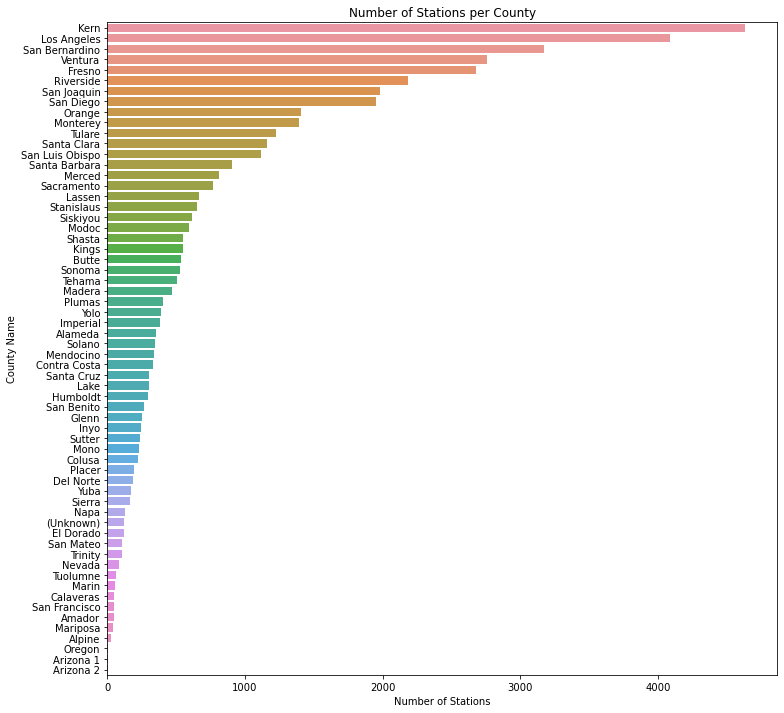

In [9]:
county_station_counts = st['county_name'].value_counts().reset_index()
county_station_counts.columns = ['county_name', 'station_count']

plt.figure(figsize=(12, 12))
sns.barplot(x='station_count', y='county_name', data=county_station_counts)
plt.xlabel('Number of Stations')
plt.ylabel('County Name')
plt.title('Number of Stations per County')
plt.show()


In [10]:
san_diego_stations_count = st[st['county_name'] == 'San Diego'].shape[0]
print("number of San Diego stations:", san_diego_stations_count)

number of San Diego stations: 1948


We have the option to filter for San Diego stations during data processing. This will leave us with 1948 stations remaining.

**See Distribution of Station Types**

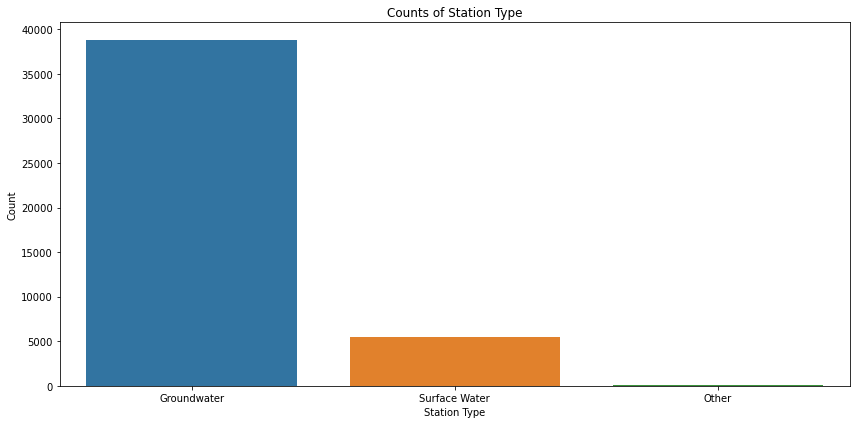

In [11]:
#get count of station types
station_type_counts = st['station_type'].value_counts()

#generate plot
plt.figure(figsize=(12, 6))
sns.barplot(x=station_type_counts.index, y=station_type_counts.values)
plt.xlabel('Station Type')
plt.ylabel('Count')
plt.title('Counts of Station Type')
plt.tight_layout()
plt.show()


## Explore Period of Record

In [12]:
por.info()
por.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733915 entries, 0 to 733914
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   station_id         733915 non-null  int64  
 1   station_name       733915 non-null  object 
 2   full_station_name  733915 non-null  object 
 3   station_number     733915 non-null  object 
 4   station_type       733915 non-null  object 
 5   latitude           723662 non-null  float64
 6   longitude          723662 non-null  float64
 7   county_name        733915 non-null  object 
 8   parameter          733915 non-null  object 
 9   sample_count       733915 non-null  int64  
 10  sample_date_min    733915 non-null  object 
 11  sample_date_max    733915 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 67.2+ MB


,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,county_name,parameter,sample_count,sample_date_min,sample_date_max
0,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0,-121.0,Yolo,Dissolved Aluminum,1,06/23/2008 15:00,06/23/2008 15:00
1,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0,-121.0,Yolo,Dissolved Antimony,1,06/23/2008 15:00,06/23/2008 15:00
2,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0,-121.0,Yolo,Dissolved Arsenic,1,06/23/2008 15:00,06/23/2008 15:00
3,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0,-121.0,Yolo,Dissolved Barium,1,06/23/2008 15:00,06/23/2008 15:00
4,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0,-121.0,Yolo,Dissolved Beryllium,1,06/23/2008 15:00,06/23/2008 15:00


**Examine the Date Range of Water Quality Collection**

In [13]:
#first convert dates in por to datetime
por['sample_date_min'] = pd.to_datetime(por['sample_date_min'])
por['sample_date_max'] = pd.to_datetime(por['sample_date_max'])

#identify the minimum and max values
min_sample_date_min = por['sample_date_min'].min()
max_sample_date_max = por['sample_date_max'].max()

#print
print("Earliest sample_date_min:", min_sample_date_min)
print("Latest sample_date_max:", max_sample_date_max)


Earliest sample_date_min: 1903-03-23 00:00:00
Latest sample_date_max: 2024-01-04 12:59:00


## Explore Lab Results

In [14]:
lr.info()
lr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4610840 entries, 0 to 4610839
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   station_id          int64  
 1   station_name        object 
 2   full_station_name   object 
 3   station_number      object 
 4   station_type        object 
 5   latitude            float64
 6   longitude           float64
 7   status              object 
 8   county_name         object 
 9   sample_code         object 
 10  sample_date         object 
 11  sample_depth        float64
 12  sample_depth_units  object 
 13  parameter           object 
 14  result              object 
 15  reporting_limit     float64
 16  units               object 
 17  method_name         object 
dtypes: float64(4), int64(1), object(13)
memory usage: 633.2+ MB


,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,status,county_name,sample_code,sample_date,sample_depth,sample_depth_units,parameter,result,reporting_limit,units,method_name
0,8135,01S04E32C001M,01S04E32C001M,01S04E32C001M,Groundwater,37.8073,-121.5617,"Public, Review Status Unknown",Alameda,WDIS_0719152,05/03/1967 09:00,NaN,Feet,Conductance,3480,1.0,uS/cm,EPA 120.1
1,8135,01S04E32C001M,01S04E32C001M,01S04E32C001M,Groundwater,37.8073,-121.5617,"Public, Review Status Unknown",Alameda,WDIS_0719152,05/03/1967 09:00,NaN,Feet,Dissolved Boron,7.7,0.1,mg/L,"Std Method 4500-B, C"
2,8135,01S04E32C001M,01S04E32C001M,01S04E32C001M,Groundwater,37.8073,-121.5617,"Public, Review Status Unknown",Alameda,WDIS_0719152,05/03/1967 09:00,NaN,Feet,Dissolved Calcium,68,1.0,mg/L,EPA 215.2
3,8135,01S04E32C001M,01S04E32C001M,01S04E32C001M,Groundwater,37.8073,-121.5617,"Public, Review Status Unknown",Alameda,WDIS_0719152,05/03/1967 09:00,NaN,Feet,Dissolved Chloride,758,0.1,mg/L,"Std Method 4500-Cl, B"
4,8135,01S04E32C001M,01S04E32C001M,01S04E32C001M,Groundwater,37.8073,-121.5617,"Public, Review Status Unknown",Alameda,WDIS_0719152,05/03/1967 09:00,NaN,Feet,Dissolved Magnesium,59,0.1,mg/L,"Std Method 3500-Mg, E"


**Investigate unique tested parameters**

In [15]:
num_unique_parameters_lr = lr['parameter'].nunique()
print("Number of measured parameters:", num_unique_parameters_lr)

Number of measured parameters: 437


This is a lot of parameters - let's just see distribution of top 30 paramters for now. Can filter later on. 

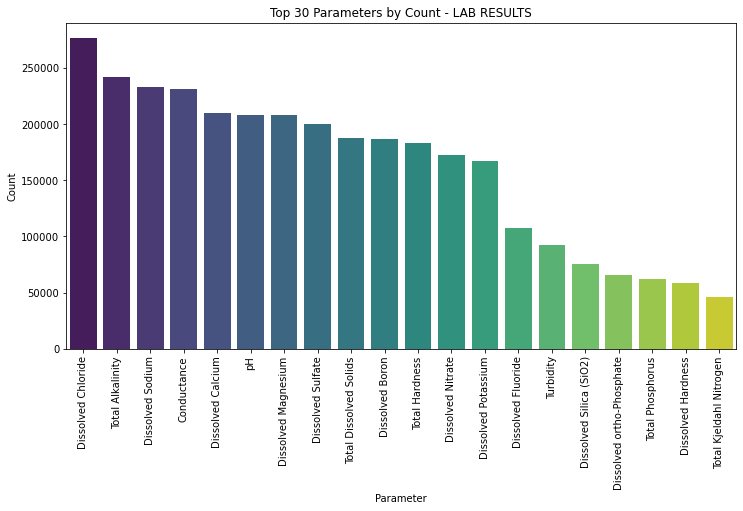

In [16]:
#get the count of each parameter in lr
parameter_counts_lr = lr['parameter'].value_counts()

#generate df for plot
parameter_counts_lr_df = parameter_counts_lr.reset_index()
parameter_counts_lr_df.columns = ['parameter', 'count']

#select top parameters, can change x
x = 20
top_x_parameters_lr = parameter_counts_lr_df.head(20)

#create barplot visualizing the top parameters
plt.figure(figsize=(12, 6))
sns.barplot(x='parameter', y='count', data=top_x_parameters_lr, palette='viridis')
plt.xlabel('Parameter')
plt.ylabel('Count')
plt.title('Top 30 Parameters by Count - LAB RESULTS')
plt.xticks(rotation=90)
plt.show()


## Explore Field Results

In [17]:
fr.info()
fr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199457 entries, 0 to 1199456
Data columns (total 22 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   station_id           1199457 non-null  int64  
 1   station_name         1199457 non-null  object 
 2   station_number       1199457 non-null  object 
 3   full_station_name    1199457 non-null  object 
 4   station_type         1199457 non-null  object 
 5   latitude             1187572 non-null  float64
 6   longitude            1187572 non-null  float64
 7   status               1199457 non-null  object 
 8   county_name          1199457 non-null  object 
 9   sample_code          1199457 non-null  object 
 10  sample_date          1199457 non-null  object 
 11  sample_depth         634376 non-null   float64
 12  sample_depth_units   1199457 non-null  object 
 13  anl_data_type        136604 non-null   object 
 14  parameter            1199457 non-null  object 
 15

,station_id,station_name,station_number,full_station_name,station_type,latitude,longitude,status,county_name,sample_code,...,sample_depth_units,anl_data_type,parameter,fdr_result,fdr_text_result,fdr_date_result,fdr_reporting_limit,uns_name,mth_name,fdr_footnote
0,12,H.O. Banks Headworks,KA000331,Delta P.P. Headworks at H.O. Banks PP,Surface Water,37.8019,-121.6203,"Public, Review Status Unknown",Alameda,OM0168A0001,...,Feet,NaN,DissolvedOxygen,9.2,NaN,NaN,0.2,mg/L,EPA 360.2 (Field),NaN
1,12,H.O. Banks Headworks,KA000331,Delta P.P. Headworks at H.O. Banks PP,Surface Water,37.8019,-121.6203,"Public, Review Status Unknown",Alameda,OM0168A0001,...,Feet,NaN,ElectricalConductance,515.0,NaN,NaN,1.0,uS/cm,Std Method 2510-B (Field),NaN
2,12,H.O. Banks Headworks,KA000331,Delta P.P. Headworks at H.O. Banks PP,Surface Water,37.8019,-121.6203,"Public, Review Status Unknown",Alameda,OM0168A0001,...,Feet,NaN,WaterTemperature,6.7,NaN,NaN,0.1,°C,EPA 170.1 (Field),NaN
3,12,H.O. Banks Headworks,KA000331,Delta P.P. Headworks at H.O. Banks PP,Surface Water,37.8019,-121.6203,"Public, Review Status Unknown",Alameda,OM0168A0001,...,Feet,NaN,pH,7.3,NaN,NaN,0.1,pH Units,EPA 150.1 (Field),NaN
4,12,H.O. Banks Headworks,KA000331,Delta P.P. Headworks at H.O. Banks PP,Surface Water,37.8019,-121.6203,"Public, Review Status Unknown",Alameda,OM0268A0006,...,Feet,NaN,DissolvedOxygen,9.7,NaN,NaN,0.2,mg/L,EPA 360.2 (Field),NaN


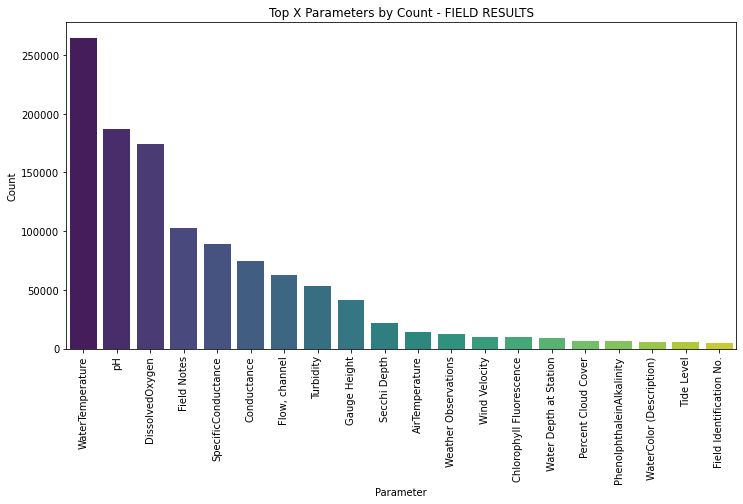

In [18]:
#get the count of each parameter in fr
parameter_counts_fr = fr['parameter'].value_counts()

#generate df for plot
parameter_counts_fr_df = parameter_counts_fr.reset_index()
parameter_counts_fr_df.columns = ['parameter', 'count']

#select top parameters, can change x
x = 20
top_x_parameters_fr = parameter_counts_fr_df.head(20)

#create barplot visualizing the top parameters
plt.figure(figsize=(12, 6))
sns.barplot(x='parameter', y='count', data=top_x_parameters_fr, palette='viridis')
plt.xlabel('Parameter')
plt.ylabel('Count')
plt.title('Top X Parameters by Count - FIELD RESULTS')
plt.xticks(rotation=90)
plt.show()


# Data Preparation 


## Handle Missing Values

In [19]:
# Identify missing values
missing_values_st = st.isnull().sum()
missing_values_por = por.isnull().sum()
missing_values_fr = fr.isnull().sum()
missing_values_lr = lr.isnull().sum()

# Print missing value counts for each dataset
print("Missing Values in Stations dataset:")
print(missing_values_st)
print("\nMissing Values in Period of Record dataset:")
print(missing_values_por)
print("\nMissing Values in Field Results dataset:")
print(missing_values_fr)
print("\nMissing Values in Lab Results dataset:")
print(missing_values_lr)



Missing Values in Stations dataset:
station_id             0
station_name           0
full_station_name      0
station_number         0
station_type           0
latitude             278
longitude            278
county_name            0
sample_count           0
sample_date_min        0
sample_date_max        0
dtype: int64

Missing Values in Period of Record dataset:
station_id               0
station_name             0
full_station_name        0
station_number           0
station_type             0
latitude             10253
longitude            10253
county_name              0
parameter                0
sample_count             0
sample_date_min          0
sample_date_max          0
dtype: int64

Missing Values in Field Results dataset:
station_id                   0
station_name                 0
station_number               0
full_station_name            0
station_type                 0
latitude                 11885
longitude                11885
status                       0
coun

## Creating a Subset of San Diego in Station Dataset

In [20]:
# Create a subset of the data for San Diego County
st_sanDiego = st[st['county_name'] == 'San Diego']

# Show the total count of rows in st_sanDiego dataframe
print("Total count of rows in st_sanDiego dataframe:", st_sanDiego.shape[0])

#Identify missing values
missing_values_st_sanDiego = st_sanDiego.isnull().sum()

# Print missing value counts for each dataset
print("Missing Values in for San Diego county in Stations dataset:")
print(missing_values_st_sanDiego)

# Calculate the percentage of missing values for latitude and longitude columns in st
percentage_missing_latitude_st_sanDiego = (st_sanDiego['latitude'].isnull().sum() / len(st_sanDiego)) * 100
percentage_missing_longitude_st_sanDiego = (st_sanDiego['longitude'].isnull().sum() / len(st_sanDiego)) * 100

print("Percentage of missing values in latitude San Diego County (Stations):", percentage_missing_latitude_st_sanDiego)
print("Percentage of missing values in longitude San Diego County (Stations):", percentage_missing_longitude_st_sanDiego)


Total count of rows in st_sanDiego dataframe: 1948
Missing Values in for San Diego county in Stations dataset:
station_id           0
station_name         0
full_station_name    0
station_number       0
station_type         0
latitude             2
longitude            2
county_name          0
sample_count         0
sample_date_min      0
sample_date_max      0
dtype: int64
Percentage of missing values in latitude San Diego County (Stations): 0.10266940451745381
Percentage of missing values in longitude San Diego County (Stations): 0.10266940451745381


In [21]:
# Drop rows with missing latitude and longitude values in st_sanDiego
st_sanDiego.dropna(subset=['latitude', 'longitude'], inplace=True)

# Identify missing values
missing_values_st_sanDiego = st_sanDiego.isnull().sum()

# Print missing value counts for each dataset
print("Missing Values in San Diego County Stations dataset:")
print(missing_values_st_sanDiego)

# Show the total count of rows after dropping missing values
print("Total count of rows in st_sanDiego dataframe after dropping missing values:", st_sanDiego.shape[0])


Missing Values in San Diego County Stations dataset:
station_id           0
station_name         0
full_station_name    0
station_number       0
station_type         0
latitude             0
longitude            0
county_name          0
sample_count         0
sample_date_min      0
sample_date_max      0
dtype: int64
Total count of rows in st_sanDiego dataframe after dropping missing values: 1946


## Creating a subset in San Diego county in Lab Results 

In [22]:
# Create a subset of the data for San Diego County
lr_sanDiego = lr[lr['county_name'] == 'San Diego']

# Show the total count of rows in lr_sanDiego dataframe
print("Total count of rows in lr_sanDiego dataframe:", lr_sanDiego.shape[0])

#Identify missing values
missing_values_lr_sanDiego = lr_sanDiego.isnull().sum()

# Print missing value counts for each dataset
print("Missing Values in for San Diego county in Lab Result dataset:")
print(missing_values_lr_sanDiego)


Total count of rows in lr_sanDiego dataframe: 101507
Missing Values in for San Diego county in Lab Result dataset:
station_id                 0
station_name               0
full_station_name          0
station_number             0
station_type               0
latitude                  29
longitude                 29
status                     0
county_name                0
sample_code                0
sample_date                0
sample_depth          101069
sample_depth_units         0
parameter                  0
result                   213
reporting_limit          213
units                      0
method_name                0
dtype: int64


In [23]:
# Calculate the percentage of missing values for other columns
percentage_missing_latitude_lr_sanDiego = (lr_sanDiego['latitude'].isnull().sum() / lr_sanDiego.shape[0]) * 100
percentage_missing_longitude_lr_sanDiego = (lr_sanDiego['longitude'].isnull().sum() / lr_sanDiego.shape[0]) * 100
percentage_missing_sample_depth_lr_sanDiego = (lr_sanDiego['sample_depth'].isnull().sum() / len(lr_sanDiego)) * 100
percentage_missing_result_lr_sanDiego = (lr_sanDiego['result'].isnull().sum() / len(lr_sanDiego)) * 100
percentage_missing_reporting_limit_lr_sanDiego = (lr_sanDiego['reporting_limit'].isnull().sum() / len(lr_sanDiego)) * 100

# Print the percentage of missing values for other columns
print("Percentage of missing values in latitude (Lab Results):", percentage_missing_latitude_lr_sanDiego)
print("Percentage of missing values in longitude (Lab Results):", percentage_missing_longitude_lr_sanDiego)
print("Percentage of missing values in sample depth (Lab Results):", percentage_missing_sample_depth_lr_sanDiego)
print("Percentage of missing values in result type (Lab Results):", percentage_missing_result_lr_sanDiego)
print("Percentage of missing values in reporting limit (Lab Results):", percentage_missing_reporting_limit_lr_sanDiego)


Percentage of missing values in latitude (Lab Results): 0.02856945826396209
Percentage of missing values in longitude (Lab Results): 0.02856945826396209
Percentage of missing values in sample depth (Lab Results): 99.56850266484085
Percentage of missing values in result type (Lab Results): 0.20983774518013534
Percentage of missing values in reporting limit (Lab Results): 0.20983774518013534


In [24]:
# Drop rows with missing latitude and longitude values in lr_sanDiego
lr_sanDiego.dropna(subset=['latitude', 'longitude', 'result'], inplace=True)

# Confirm that missing values have been handled
print("Missing values in lr_sanDiego after handling:")
print(lr_sanDiego.isnull().sum())

# Show the total count of rows after dropping missing values
print("Total count of rows in lr_sanDiego dataframe after dropping missing values:", lr_sanDiego.shape[0])


Missing values in lr_sanDiego after handling:
station_id                 0
station_name               0
full_station_name          0
station_number             0
station_type               0
latitude                   0
longitude                  0
status                     0
county_name                0
sample_code                0
sample_date                0
sample_depth          100838
sample_depth_units         0
parameter                  0
result                     0
reporting_limit            0
units                      0
method_name                0
dtype: int64
Total count of rows in lr_sanDiego dataframe after dropping missing values: 101267


In [25]:

# Calculate the mode value of 'sample_depth' column
mode_sample_depth = lr_sanDiego['sample_depth'].mode()[0]

# Replace missing values in 'sample_depth' column with the mode
lr_sanDiego['sample_depth'].fillna(mode_sample_depth, inplace=True)

# Confirm that missing values have been handled
print("Missing values in lr_sanDiego after handling:")
print(lr_sanDiego.isnull().sum())

#Show the total count of rows after dropping missing values
print("Total count of rows in lr_sanDiego dataframe after dropping missing values:", lr_sanDiego.shape[0])


Missing values in lr_sanDiego after handling:
station_id            0
station_name          0
full_station_name     0
station_number        0
station_type          0
latitude              0
longitude             0
status                0
county_name           0
sample_code           0
sample_date           0
sample_depth          0
sample_depth_units    0
parameter             0
result                0
reporting_limit       0
units                 0
method_name           0
dtype: int64
Total count of rows in lr_sanDiego dataframe after dropping missing values: 101267


## Handling Missing Values in Period of Record Dataset

In [26]:
# Create a subset of the data for San Diego County
por_sanDiego = por[por['county_name'] == 'San Diego']

# Show the total count of rows in st_sanDiego dataframe
print("Total count of rows in por_sanDiego dataframe:", por_sanDiego.shape[0])

#Identify missing values
missing_values_por_sanDiego = por_sanDiego.isnull().sum()

#Print missing value counts for period of record dataset
print("Missing Values in for San Diego county in period of record dataset:")
print(missing_values_por_sanDiego)


Total count of rows in por_sanDiego dataframe: 26410
Missing Values in for San Diego county in period of record dataset:
station_id            0
station_name          0
full_station_name     0
station_number        0
station_type          0
latitude             29
longitude            29
county_name           0
parameter             0
sample_count          0
sample_date_min       0
sample_date_max       0
dtype: int64


## Creating a Subset of San Diego in Field Result Dataset

In [27]:
# Create a subset of the data for San Diego County
fr_sanDiego = fr[fr['county_name'] == 'San Diego']

# Show the total count of rows in st_sanDiego dataframe
print("Total count of rows in fr_sanDiego dataframe:", fr_sanDiego.shape[0])

#Identify missing values
missing_values_fr_sanDiego = fr_sanDiego.isnull().sum()

# Print missing value counts for each dataset
print("Missing Values in for San Diego county in field results dataset:")
print(missing_values_fr_sanDiego)

# Calculate the total count of null values in the fr_sanDiego subset dataset
total_null_count_fr_sanDiego = fr_sanDiego.isnull().sum().sum()

# Print the total count of null values
print("Total count of null values in fr_sanDiego dataset:", total_null_count_fr_sanDiego)

# Calculate the total number of data points in fr_sanDiego
total_data_points_fr_sanDiego = fr_sanDiego.size

# Calculate the percentage of missing values
percentage_missing_values_fr_sanDiego = (total_null_count_fr_sanDiego / total_data_points_fr_sanDiego) * 100

# Print the percentage of missing values
print("Percentage of missing values in fr_sanDiego dataset:", percentage_missing_values_fr_sanDiego)



Total count of rows in fr_sanDiego dataframe: 9051
Missing Values in for San Diego county in field results dataset:
station_id                0
station_name              0
station_number            0
full_station_name         0
station_type              0
latitude                  5
longitude                 5
status                    0
county_name               0
sample_code               0
sample_date               0
sample_depth           8698
sample_depth_units        0
anl_data_type          7973
parameter                 0
fdr_result             1083
fdr_text_result        7998
fdr_date_result        9045
fdr_reporting_limit    1114
uns_name                  0
mth_name                  0
fdr_footnote           8080
dtype: int64
Total count of null values in fr_sanDiego dataset: 44001
Percentage of missing values in fr_sanDiego dataset: 22.097508060385092


In [28]:

# Calculate the percentage of missing values for other columns
percentage_missing_latitude_fr_sanDiego = (fr_sanDiego['latitude'].isnull().sum() / fr_sanDiego.shape[0]) * 100
percentage_missing_longitude_fr_sanDiego = (fr_sanDiego['longitude'].isnull().sum() / fr_sanDiego.shape[0]) * 100
percentage_missing_sample_depth_fr_sanDiego = (fr_sanDiego['sample_depth'].isnull().sum() / len(fr_sanDiego)) * 100
percentage_missing_analysis_type_fr_sanDiego = (fr_sanDiego['anl_data_type'].isnull().sum() / len(fr_sanDiego)) * 100
percentage_missing_field_result_fr_sanDiego = (fr_sanDiego['fdr_result'].isnull().sum() / len(fr_sanDiego)) * 100
percentage_missing_field_result_text_fr_sanDiego = (fr_sanDiego['fdr_text_result'].isnull().sum() / len(fr_sanDiego)) * 100
percentage_missing_field_result_date_fr_sanDiego = (fr_sanDiego['fdr_date_result'].isnull().sum() / len(fr_sanDiego)) * 100
percentage_missing_reporting_limit_fr_sanDiego = (fr_sanDiego['fdr_reporting_limit'].isnull().sum() / len(fr_sanDiego)) * 100
percentage_missing_field_result_footnote_fr_sanDiego = (fr_sanDiego['fdr_footnote'].isnull().sum() / len(fr_sanDiego)) * 100

# Print the percentage of missing values for other columns
print("Percentage of missing values in latitude (Field Results):", percentage_missing_latitude_fr_sanDiego)
print("Percentage of missing values in longitude (Field Results):", percentage_missing_longitude_fr_sanDiego)
print("Percentage of missing values in sample depth (Field Results):", percentage_missing_sample_depth_fr_sanDiego)
print("Percentage of missing values in analysis data type (Field Results):", percentage_missing_analysis_type_fr_sanDiego)
print("Percentage of missing values in field result (Field Results):", percentage_missing_field_result_fr_sanDiego)
print("Percentage of missing values in field result text (Field Results):", percentage_missing_field_result_text_fr_sanDiego)
print("Percentage of missing values in field result date (Field Results):", percentage_missing_field_result_date_fr_sanDiego)
print("Percentage of missing values in field result reporting limit (Field Results):", percentage_missing_reporting_limit_fr_sanDiego)
print("Percentage of missing values in field result footnote (Field Results):", percentage_missing_field_result_footnote_fr_sanDiego)


Percentage of missing values in latitude (Field Results): 0.055242514639266375
Percentage of missing values in longitude (Field Results): 0.055242514639266375
Percentage of missing values in sample depth (Field Results): 96.09987846646779
Percentage of missing values in analysis data type (Field Results): 88.08971384377416
Percentage of missing values in field result (Field Results): 11.965528670865098
Percentage of missing values in field result text (Field Results): 88.3659264169705
Percentage of missing values in field result date (Field Results): 99.93370898243288
Percentage of missing values in field result reporting limit (Field Results): 12.308032261628549
Percentage of missing values in field result footnote (Field Results): 89.27190365705448


In [29]:
# Drop rows with missing latitude and longitude values in fr_sanDiego
fr_sanDiego.dropna(subset=['latitude', 'longitude'], inplace=True)

# Replace missing values in other columns with mean values
fr_sanDiego['fdr_result'].fillna(fr_sanDiego['fdr_result'].mean(), inplace=True)
fr_sanDiego['fdr_reporting_limit'].fillna(fr_sanDiego['fdr_reporting_limit'].mean(), inplace=True)

# Confirm that missing values have been handled
print("Missing values in fr_sanDiego after handling:")
print(fr_sanDiego.isnull().sum())


Missing values in fr_sanDiego after handling:
station_id                0
station_name              0
station_number            0
full_station_name         0
station_type              0
latitude                  0
longitude                 0
status                    0
county_name               0
sample_code               0
sample_date               0
sample_depth           8693
sample_depth_units        0
anl_data_type          7968
parameter                 0
fdr_result                0
fdr_text_result        7993
fdr_date_result        9040
fdr_reporting_limit       0
uns_name                  0
mth_name                  0
fdr_footnote           8075
dtype: int64


In [30]:
# Calculate the mode value for each column
sample_depth_mode = fr_sanDiego['sample_depth'].mode()[0]
anl_data_type_mode = fr_sanDiego['anl_data_type'].mode()[0]
fdr_text_result_mode = fr_sanDiego['fdr_text_result'].mode()[0]
fdr_date_result_mode = fr_sanDiego['fdr_date_result'].mode()[0]
fdr_footnote_mode = fr_sanDiego['fdr_footnote'].mode()[0]

# Replace missing values with mode values
fr_sanDiego['sample_depth'].fillna(sample_depth_mode, inplace=True)
fr_sanDiego['anl_data_type'].fillna(anl_data_type_mode, inplace=True)
fr_sanDiego['fdr_text_result'].fillna(fdr_text_result_mode, inplace=True)
fr_sanDiego['fdr_date_result'].fillna(fdr_date_result_mode, inplace=True)
fr_sanDiego['fdr_footnote'].fillna(fdr_footnote_mode, inplace=True)

# Print the null counts after handling missing values
print("Missing values in fr_sanDiego after handling:")
print(fr_sanDiego.isnull().sum())


Missing values in fr_sanDiego after handling:
station_id             0
station_name           0
station_number         0
full_station_name      0
station_type           0
latitude               0
longitude              0
status                 0
county_name            0
sample_code            0
sample_date            0
sample_depth           0
sample_depth_units     0
anl_data_type          0
parameter              0
fdr_result             0
fdr_text_result        0
fdr_date_result        0
fdr_reporting_limit    0
uns_name               0
mth_name               0
fdr_footnote           0
dtype: int64


## Outliers Exploration

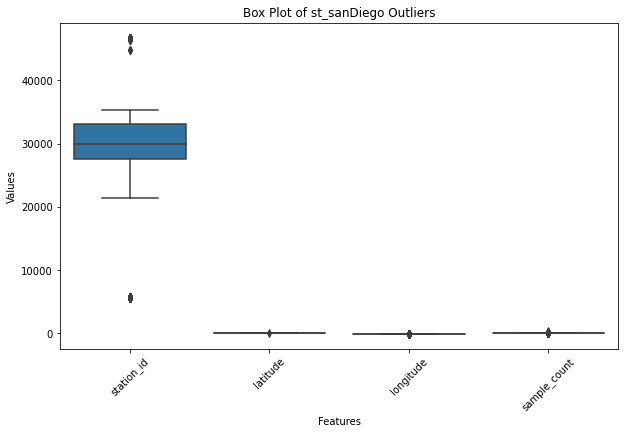

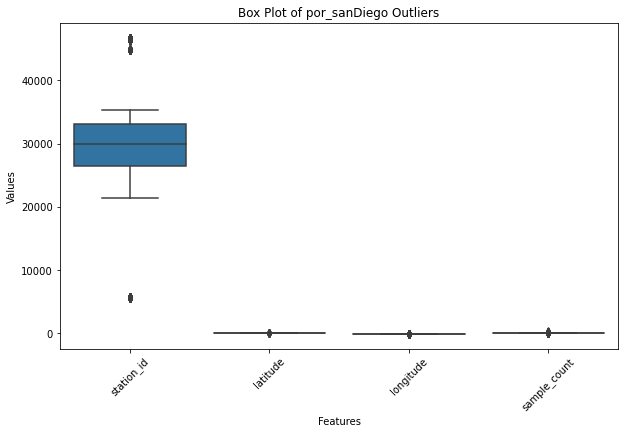

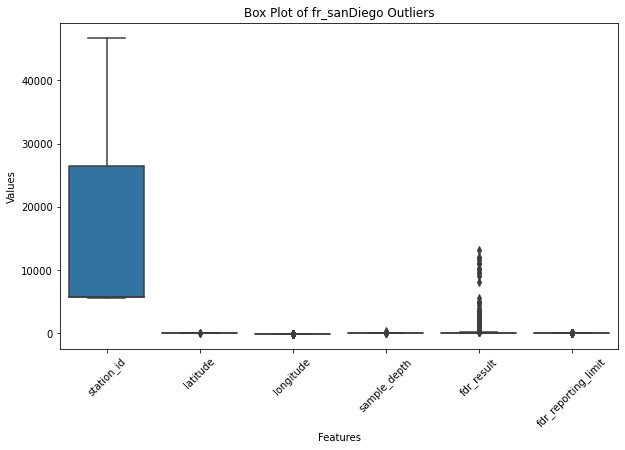

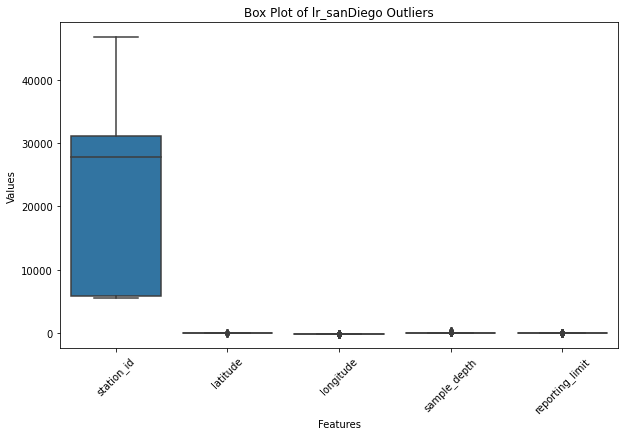

In [31]:
# Create box plots for each dataset to visualize outliers

plt.figure(figsize=(10, 6))
sns.boxplot(data=st_sanDiego)  
plt.title('Box Plot of st_sanDiego Outliers')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=por_sanDiego)  
plt.title('Box Plot of por_sanDiego Outliers')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=fr_sanDiego)  
plt.title('Box Plot of fr_sanDiego Outliers')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=lr_sanDiego)  
plt.title('Box Plot of lr_sanDiego Outliers')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()


## Data Type and Unit Conversions

* **Convert sample_date_min and sample_date_max columns to datetime objects to facilitate time-based analysis**


In [32]:
st_sanDiego['sample_date_min'] = pd.to_datetime(st_sanDiego['sample_date_min'], format='%m/%d/%Y %H:%M')
st_sanDiego['sample_date_max'] = pd.to_datetime(st_sanDiego['sample_date_max'], format='%m/%d/%Y %H:%M')

por_sanDiego['sample_date_min'] = pd.to_datetime(por_sanDiego['sample_date_min'], format='%m/%d/%Y %H:%M')
por_sanDiego['sample_date_max'] = pd.to_datetime(por_sanDiego['sample_date_max'], format='%m/%d/%Y %H:%M')

fr_sanDiego['sample_date'] = pd.to_datetime(fr_sanDiego['sample_date'], format='%Y-%m-%d %H:%M:%S')
lr_sanDiego['sample_date'] = pd.to_datetime(lr_sanDiego['sample_date'], format='%m/%d/%Y %H:%M')


* Check unit types

In [88]:
fr_sanDiego.head()

,station_id,station_name,station_number,full_station_name,station_type,latitude,longitude,status,county_name,sample_code,...,anl_data_type,parameter,fdr_result,fdr_text_result,fdr_date_result,fdr_reporting_limit,uns_name,mth_name,fdr_footnote,station_name_encoded
682387,5576,GRAPEVINE CYN CR AT,W4520000,GRAPEVINE CYN CR AT ANGELINA SPR,Surface Water,33.1542,-116.48,"Public, Review Status Unknown",San Diego,WDIS_0226099,...,Memo,Field Notes,172.100771,*See Units Note,1899-12-30,0.302572,,Notes (Field),DO Units Note - mg/L: WDIS DO Units not specif...,974
682388,5576,GRAPEVINE CYN CR AT,W4520000,GRAPEVINE CYN CR AT ANGELINA SPR,Surface Water,33.1542,-116.48,"Public, Review Status Unknown",San Diego,WDIS_0226099,...,Memo,Conductance,1250.000000,*See Units Note,1899-12-30,1.000000,uS/cm,Std Method 2510-B (Field),DO Units Note - mg/L: WDIS DO Units not specif...,974
682389,5576,GRAPEVINE CYN CR AT,W4520000,GRAPEVINE CYN CR AT ANGELINA SPR,Surface Water,33.1542,-116.48,"Public, Review Status Unknown",San Diego,WDIS_0226099,...,Memo,DissolvedOxygen,6.300000,*See Units Note,1899-12-30,0.200000,mg/L,EPA 360.2 (Field),DO Units Note - mg/L: WDIS DO Units not specif...,974
682390,5576,GRAPEVINE CYN CR AT,W4520000,GRAPEVINE CYN CR AT ANGELINA SPR,Surface Water,33.1542,-116.48,"Public, Review Status Unknown",San Diego,WDIS_0226099,...,Memo,"Flow, channel",0.000000,*See Units Note,1899-12-30,1.000000,cfs,"Flow, Channel",DO Units Note - mg/L: WDIS DO Units not specif...,974
682391,5576,GRAPEVINE CYN CR AT,W4520000,GRAPEVINE CYN CR AT ANGELINA SPR,Surface Water,33.1542,-116.48,"Public, Review Status Unknown",San Diego,WDIS_0226099,...,Memo,WaterTemperature,21.666667,*See Units Note,1899-12-30,0.100000,°C,EPA 170.1 (Field),DO Units Note - mg/L: WDIS DO Units not specif...,974


* **Convert any Temperature Data Collected in Fahrenheit to Celcius**

In [33]:

# Convert 'fdr_result WaterTemperature' from Fahrenheit to Celsius if 'uns_name WaterTemperature' is '°F'
fahrenheit_mask = fr_sanDiego['uns_name'] == '°F'
fr_sanDiego.loc[fahrenheit_mask, 'fdr_result'] = (
    (fr_sanDiego.loc[fahrenheit_mask, 'fdr_result'] - 32) * 5/9
)

# Change 'uns_name WaterTemperature' to '°C' for rows where temperature is in Celsius
fr_sanDiego.loc[fahrenheit_mask, 'uns_name'] = '°C'

## One hot encoding for categorical data

In [34]:
st_sanDiego = pd.get_dummies(st_sanDiego, columns=['station_type'], prefix='station_type')


In [35]:
# label encoding using sklearn
label_encoder = LabelEncoder()

#encode stations dataframe, San Diego subset
st_sanDiego['station_name_encoded'] = label_encoder.fit_transform(st_sanDiego['station_name'])

fr_sanDiego['station_name_encoded'] = label_encoder.fit_transform(fr_sanDiego['station_name'])

por_sanDiego['station_name_encoded'] = label_encoder.fit_transform(por_sanDiego['station_name'])

lr_sanDiego['station_name_encoded'] = label_encoder.fit_transform(lr_sanDiego['station_name'])


## Dropping Unnecessary Columns for each dataset

**Stations dataframe columns**

In [36]:
# Define the columns to keep
st_sanDiego_columns = ['station_id', 'latitude', 'longitude', 'county_name']

# Filter the DataFrame to keep only the desired columns
st_sanDiego_df = st_sanDiego[st_sanDiego_columns]

print(st_sanDiego_df.head())  


       station_id  latitude  longitude county_name
15284       21453   33.6110  -117.6241   San Diego
16696       22879   33.5428  -117.1425   San Diego
16735       22919   33.5825  -117.2447   San Diego
17749       23932   33.4289  -116.8370   San Diego
17851       24039   33.4330  -117.2228   San Diego


**Period of record dataframe columns**

In [37]:
por_sanDiego_columns = ['station_id', 'latitude', 'longitude', 'county_name', 'parameter']

# Filter the DataFrame to keep only the desired columns
por_sanDiego_df = por_sanDiego[por_sanDiego_columns]

print(por_sanDiego_df.head())  

        station_id  latitude  longitude county_name           parameter
211730       21453    33.611  -117.6241   San Diego         Conductance
211731       21453    33.611  -117.6241   San Diego     Dissolved Boron
211732       21453    33.611  -117.6241   San Diego   Dissolved Calcium
211733       21453    33.611  -117.6241   San Diego  Dissolved Chloride
211734       21453    33.611  -117.6241   San Diego  Dissolved Fluoride


**Field Results dataframe columns**

In [38]:
# Define the columns to keep
fr_sanDiego_columns = ['station_id', 'latitude', 'longitude', 'sample_date','county_name', 'parameter', 'fdr_result', 'uns_name']

# Filter the DataFrame to keep only the desired columns
fr_sanDiego_df = fr_sanDiego[fr_sanDiego_columns]

print(fr_sanDiego_df.head())  
fr_sanDiego_df.head()

        station_id  latitude  longitude         sample_date county_name  \
682387        5576   33.1542    -116.48 1988-04-27 11:00:00   San Diego   
682388        5576   33.1542    -116.48 1988-04-27 11:00:00   San Diego   
682389        5576   33.1542    -116.48 1988-04-27 11:00:00   San Diego   
682390        5576   33.1542    -116.48 1988-04-27 11:00:00   San Diego   
682391        5576   33.1542    -116.48 1988-04-27 11:00:00   San Diego   

               parameter   fdr_result uns_name  
682387       Field Notes   172.100771           
682388       Conductance  1250.000000    uS/cm  
682389   DissolvedOxygen     6.300000     mg/L  
682390     Flow, channel     0.000000      cfs  
682391  WaterTemperature    21.666667       °C  


,station_id,latitude,longitude,sample_date,county_name,parameter,fdr_result,uns_name
682387,5576,33.1542,-116.48,1988-04-27 11:00:00,San Diego,Field Notes,172.100771,
682388,5576,33.1542,-116.48,1988-04-27 11:00:00,San Diego,Conductance,1250.000000,uS/cm
682389,5576,33.1542,-116.48,1988-04-27 11:00:00,San Diego,DissolvedOxygen,6.300000,mg/L
682390,5576,33.1542,-116.48,1988-04-27 11:00:00,San Diego,"Flow, channel",0.000000,cfs
682391,5576,33.1542,-116.48,1988-04-27 11:00:00,San Diego,WaterTemperature,21.666667,°C


**Lab results dataframe columns**

In [39]:
# Define the columns to keep
lr_sanDiego_columns = ['station_id', 'sample_date', 'latitude', 'longitude', 'county_name', 'parameter', 'result', 'units']

# Filter the DataFrame to keep only the desired columns
lr_sanDiego_df = lr_sanDiego[lr_sanDiego_columns]

print(lr_sanDiego_df.head())  


         station_id sample_date  latitude  longitude county_name  \
3092634       21453  1964-07-16    33.611  -117.6241   San Diego   
3092635       21453  1964-07-16    33.611  -117.6241   San Diego   
3092636       21453  1964-07-16    33.611  -117.6241   San Diego   
3092637       21453  1964-07-16    33.611  -117.6241   San Diego   
3092638       21453  1964-07-16    33.611  -117.6241   San Diego   

                  parameter result  units  
3092634         Conductance    660  uS/cm  
3092635     Dissolved Boron    .02   mg/L  
3092636   Dissolved Calcium     61   mg/L  
3092637  Dissolved Chloride     69   mg/L  
3092638  Dissolved Fluoride     .2   mg/L  


## Reformat Lab and Field Results; Extract Top Parameters as Fields, Save Units

**Filter for which parameters to keep in lab and field results**

In [40]:
lr_filter = ['Dissolved Chlorine', 'Total Alkalinity', 'Dissolved Sodium', 'Conductance', 'Dissolved Calcium', 'pH']
fr_filter = ['WaterTemperature','pH','DissolvedOxygen','SpecificConductance','Conductance','Turbidity']

lr_sanDiego_df_filtered = lr_sanDiego_df[lr_sanDiego_df['parameter'].isin(lr_filter)]
fr_sanDiego_df_filtered = fr_sanDiego_df[fr_sanDiego_df['parameter'].isin(fr_filter)]

**Make table containing the unit types, ensure that chosen parameters all are measured in the same units**

In [91]:
units_lr_sanDiego = lr_sanDiego_df_filtered.groupby('parameter')['units'].agg(['nunique', 'unique'])
units_lr_sanDiego.columns = ['count_unique_units', 'unique_units']
units_lr_sanDiego

,count_unique_units,unique_units
parameter,,
Conductance,1,[uS/cm]
Dissolved Calcium,1,[mg/L]
Dissolved Sodium,1,[mg/L]
Total Alkalinity,1,[mg/L as CaCO3]
pH,1,[pH Units]


In [93]:
units_fr_sanDiego = fr_sanDiego_df_filtered.groupby('parameter')['uns_name'].agg(['nunique', 'unique'])
units_fr_sanDiego.columns = ['count_unique_units', 'unique_units']
units_fr_sanDiego

,count_unique_units,unique_units
parameter,,
Conductance,1,[uS/cm]
DissolvedOxygen,1,[mg/L]
SpecificConductance,1,[uS/cm@25 °C]
WaterTemperature,1,[°C]
pH,1,[pH Units]


**Make each parameter its own column - Lab Results**

In [41]:
pivot_lr_sd_with_units = lr_sanDiego_df_filtered.pivot_table(index=['station_id', 'sample_date', 'latitude', 'longitude', 'county_name'], 
                                                 columns='parameter', 
                                                 values=['result', 'units'], 
                                                 aggfunc={'result': 'first', 'units': 'first'}).reset_index()


pivot_lr_sd= lr_sanDiego_df_filtered.pivot_table(index=['station_id', 'sample_date', 'latitude', 'longitude', 'county_name'], 
                                                 columns='parameter', 
                                                 values=['result'], 
                                                 aggfunc={'result': 'first'}).reset_index()


#make header in same row
pivot_lr_sd.columns = [' '.join(col).strip() for col in pivot_lr_sd.columns.values]

#remove result string from column headers
pivot_lr_sd.columns = [col.replace('result ', '') for col in pivot_lr_sd.columns]

#sort by sample date
pivot_lr_sd = pivot_lr_sd.sort_values(by='sample_date')



**Make each parameter its own column - Field Results**

In [42]:
pivot_fr_sd_with_units = fr_sanDiego_df_filtered.pivot_table(index=['station_id', 'sample_date', 'latitude', 'longitude', 'county_name'], 
                                         columns='parameter', 
                                         values=['fdr_result', 'uns_name'], 
                                         aggfunc={'fdr_result': 'first', 'uns_name': 'first'}).reset_index()

pivot_fr_sd = fr_sanDiego_df_filtered.pivot_table(index=['station_id', 'sample_date', 'latitude', 'longitude', 'county_name'], 
                                         columns='parameter', 
                                         values=['fdr_result'], 
                                         aggfunc={'fdr_result': 'first'}).reset_index()

# Remove the name of the index column
pivot_fr_sd.columns = [' '.join(col).strip() for col in pivot_fr_sd.columns.values]

pivot_fr_sd.columns = [col.replace('fdr_result ', '') for col in pivot_fr_sd.columns]

pivot_fr_sd = pivot_fr_sd.sort_values(by='sample_date')

## Descriptive Statistics of Parameters

In [43]:
stats_fr = pivot_fr_sd.describe().transpose()

# Descriptive statistics for pivot_lr_sd
stats_lr = pivot_lr_sd.describe().transpose()

# Plotting
print("Descriptive Statistics for pivot_fr_sd:")
print(stats_fr)

print("\nDescriptive Statistics for pivot_lr_sd:")
print(stats_lr)

Descriptive Statistics for pivot_fr_sd:
                      count          mean           std          min  \
station_id           3857.0  21018.671506  12349.460470  5576.000000   
latitude             3857.0     33.041093      0.287922    32.541700   
longitude            3857.0   -117.112701      0.262136  -121.855400   
Conductance           597.0   1798.368509   1458.629956   176.000000   
DissolvedOxygen       966.0      8.613976      6.000063     0.400000   
SpecificConductance    26.0   1597.153846    368.421030   648.000000   
WaterTemperature     3731.0     20.300622      4.398005   -17.333333   
pH                   1212.0      7.732261      0.441947     6.400000   

                             25%         50%         75%           max  
station_id           5765.000000  27526.0000  31064.0000  46751.000000  
latitude               32.831500     33.1145     33.2660     36.568400  
longitude            -117.262500   -117.1086   -117.0342   -116.088100  
Conductance        

## Exploring New Missing Values in Results

Table of Missing Values for pivot_fr_sd:
station_id                0
sample_date               0
latitude                  0
longitude                 0
county_name               0
Conductance            3260
DissolvedOxygen        2891
SpecificConductance    3831
WaterTemperature        126
pH                     2645
dtype: int64


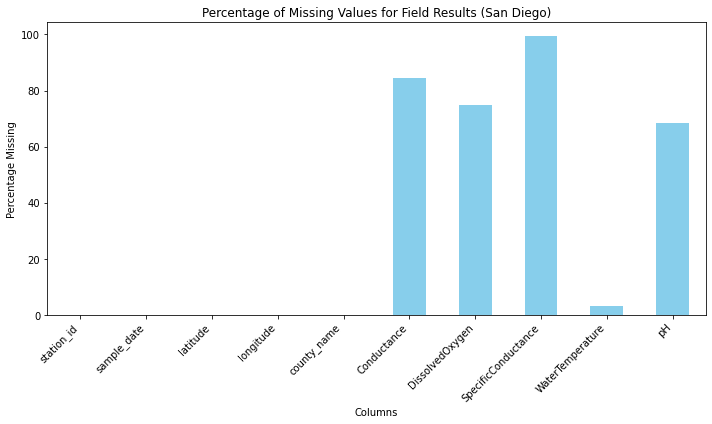

In [44]:
# Table of missing values for pivot_fr_sd
missing_values_fr = pivot_fr_sd.isnull().sum()
print("Table of Missing Values for pivot_fr_sd:")
print(missing_values_fr)

missing_percentage_fr = (pivot_fr_sd.isnull().sum() / len(pivot_fr_sd)) * 100

# Plot bar chart for missing values
plt.figure(figsize=(10, 6))
missing_percentage_fr.plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values for Field Results (San Diego)')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Exploring New Missing Values in Lab Results

Table of Missing Values for pivot_lr_sd:
station_id              0
sample_date             0
latitude                0
longitude               0
county_name             0
Conductance           736
Dissolved Calcium    1412
Dissolved Sodium     1408
Total Alkalinity      677
pH                    928
dtype: int64


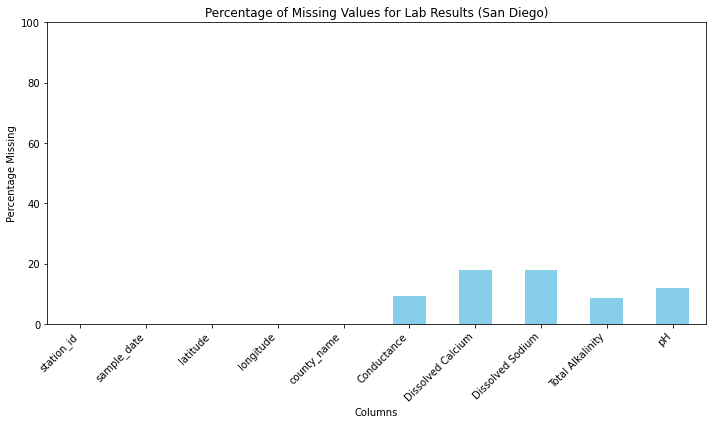

In [45]:
# Table of missing values for pivot_fr_sd
missing_values_lr = pivot_lr_sd.isnull().sum()
print("Table of Missing Values for pivot_lr_sd:")
print(missing_values_lr)

missing_percentage_lr = (pivot_lr_sd.isnull().sum() / len(pivot_lr_sd)) * 100

# Plot bar chart for missing values
plt.figure(figsize=(10, 6))
missing_percentage_lr.plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values for Lab Results (San Diego)')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')
plt.ylim(0,100)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Save transformed files as csv files in S3 bucket

**stations**

In [46]:
csv_buffer = StringIO()
st_sanDiego_df.to_csv(csv_buffer, index=False)

# Upload CSV string to S3
bucket_name = 'ads508group4finalproject'
subfolder_name = 'stations_transformed'
file_name = 'stations_transformed.csv'
s3_key = f'{subfolder_name}/{file_name}'

s3_client = boto3.client('s3')
s3_client.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=s3_key)



{'ResponseMetadata': {'RequestId': '0NYYKDR0P9H48WXY',
  'HostId': 'uGcSz+gjwQFlj0tiYC6vkKFp/pGsip2mcBb0H38eTBdawrwGZHE2h6iMEOj42FUZRGzKU4ECisM=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'uGcSz+gjwQFlj0tiYC6vkKFp/pGsip2mcBb0H38eTBdawrwGZHE2h6iMEOj42FUZRGzKU4ECisM=',
   'x-amz-request-id': '0NYYKDR0P9H48WXY',
   'date': 'Tue, 09 Apr 2024 01:11:36 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"448df0aaca6c187188c71e2f9bc7617d"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"448df0aaca6c187188c71e2f9bc7617d"',
 'ServerSideEncryption': 'AES256'}

**period of record**

In [47]:
csv_buffer = StringIO()
por_sanDiego_df.to_csv(csv_buffer, index=False)

# Upload CSV string to S3
bucket_name = 'ads508group4finalproject'
subfolder_name = 'period_of_record_transformed'
file_name = 'period_of_record_transformed.csv'
s3_key = f'{subfolder_name}/{file_name}'

s3_client = boto3.client('s3')
s3_client.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=s3_key)


{'ResponseMetadata': {'RequestId': '37D5HNTBXJS6AP7E',
  'HostId': 'GJzU3pU1qKf8+ry2FI5Ts5DsphEDuSTU1TZzoEelngTcO4t0Bg3Khgr57EaPADU+jPdceGGg0DhLSSXniUgEtD0bTol27aQla9D6eA0fVM0=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'GJzU3pU1qKf8+ry2FI5Ts5DsphEDuSTU1TZzoEelngTcO4t0Bg3Khgr57EaPADU+jPdceGGg0DhLSSXniUgEtD0bTol27aQla9D6eA0fVM0=',
   'x-amz-request-id': '37D5HNTBXJS6AP7E',
   'date': 'Tue, 09 Apr 2024 01:11:37 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"5b0b8963ac15f4ffc186de742907892a"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"5b0b8963ac15f4ffc186de742907892a"',
 'ServerSideEncryption': 'AES256'}

**field results**

In [48]:
csv_buffer = StringIO()
pivot_fr_sd.to_csv(csv_buffer, index=False)
#Upload CSV string to S3
    
bucket_name = 'ads508group4finalproject'
subfolder_name = 'field_results_transformed'
file_name = 'field_results_transformed.csv'
s3_key = f'{subfolder_name}/{file_name}'

s3_client = boto3.client('s3')
s3_client.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=s3_key)

{'ResponseMetadata': {'RequestId': '37D46R5EMWDJR7DJ',
  'HostId': 'P/Eckwfc2hlYe+dDO426Cz0qlevPIwQ8yoCFVK9K/CcopkN7LFLCAO/nPgKpJyRJ+Eqg0N9rIH0=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'P/Eckwfc2hlYe+dDO426Cz0qlevPIwQ8yoCFVK9K/CcopkN7LFLCAO/nPgKpJyRJ+Eqg0N9rIH0=',
   'x-amz-request-id': '37D46R5EMWDJR7DJ',
   'date': 'Tue, 09 Apr 2024 01:11:37 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"9ee0fa32c2df0558182a9a12bd61d803"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"9ee0fa32c2df0558182a9a12bd61d803"',
 'ServerSideEncryption': 'AES256'}

**lab results**

In [49]:
csv_buffer = StringIO()
pivot_lr_sd.to_csv(csv_buffer, index=False)


#Upload CSV string to S3
bucket_name = 'ads508group4finalproject'
subfolder_name = 'lab_results_transformed'
file_name = 'lab_results_transformed.csv'
s3_key = f'{subfolder_name}/{file_name}'

s3_client = boto3.client('s3')
s3_client.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=s3_key)

{'ResponseMetadata': {'RequestId': '37DA7A8K1Z0D0R9H',
  'HostId': 'KmatSxgrPtYfoRQaNevJe6UuPGyAL5oPZpETXX58BXrhyPsBg+ccuMt+2wM3QbC4GL99Fc4DKN8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'KmatSxgrPtYfoRQaNevJe6UuPGyAL5oPZpETXX58BXrhyPsBg+ccuMt+2wM3QbC4GL99Fc4DKN8=',
   'x-amz-request-id': '37DA7A8K1Z0D0R9H',
   'date': 'Tue, 09 Apr 2024 01:11:37 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"7a8dada489505dd453280b1fda9c6a83"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"7a8dada489505dd453280b1fda9c6a83"',
 'ServerSideEncryption': 'AES256'}

# Athena Database

## Create Database

In [50]:
#define parameters
bucket = 'ads508group4finalproject'
database_name = "ADS508Group4"
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
region = 'us-east-1'

#establish connection to Athena database
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
#create curosr object that can be used to execute queries
cur = conn.cursor()

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)

pd.read_sql(statement,conn)

statement = "SHOW DATABASES"
df_show = pd.read_sql(statement,conn)
df_show.head(5)


CREATE DATABASE IF NOT EXISTS ADS508Group4


,database_name
0,ads508group4
1,default


## Create Database Tables and import Data

**Stations Table**

In [51]:
#specify location of where the file that we will ingest data from is located
subfolder = "stations_transformed"
loc = 's3://{}/{}/'.format(bucket, subfolder)
#specify database table name
table_name = "stations"

# sql statement to make table
make_stations_table = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
        station_id int,
        latitude double,
        longitude double,
        county_name string
    ) ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LINES TERMINATED BY '\\n'
    LOCATION '{}'
    TBLPROPERTIES ('compressionType'='gzip', 'skip.header.line.count'='1')
""".format(database_name, table_name, loc)

#execute sql statement
cur.execute(make_stations_table)

#preview first 5 rows
head_query = "SELECT * FROM {}.{} LIMIT 5".format(database_name, table_name)
df_first_5_rows = pd.read_sql(head_query, conn)
print(df_first_5_rows)

  station_id  latitude  longitude county_name
0      21453   33.6110  -117.6241   San Diego
1      22879   33.5428  -117.1425   San Diego
2      22919   33.5825  -117.2447   San Diego
3      23932   33.4289  -116.8370   San Diego
4      24039   33.4330  -117.2228   San Diego


**Field Results Table**

In [52]:
#specify location of where the file that we will ingest data from is located
subfolder = "field_results_transformed"
loc = 's3://{}/{}/'.format(bucket, subfolder)
# Specify the table name
table_name = "field_results"

# SQL statement to create the table for field results
make_field_results_table = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
        station_id int,
        sample_date DATE,
        latitude double,
        longitude double,
        county_name string,
        -- Add more columns as needed based on your field results data
        Conductance double,
        DissolvedOxygen double,
        SpecificConductance double,
        WaterTemperature double,
        pH string
    ) ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LINES TERMINATED BY '\\n'
    LOCATION '{}'
    TBLPROPERTIES ('compressionType'='gzip', 'skip.header.line.count'='1')
""".format(database_name, table_name, loc)

# Execute the SQL statement to create the table
cur.execute(make_field_results_table)

# Preview first 5 rows
head_query = "SELECT * FROM {}.{} LIMIT 5".format(database_name, table_name)
df_first_5_rows = pd.read_sql(head_query, conn)
print(df_first_5_rows)

  station_id          sample_date  latitude  longitude county_name  \
0      27915  1949-12-22 00:00:00   33.2186  -117.3409   San Diego   
1      28000  1949-12-23 11:30:00   33.2112  -117.3568   San Diego   
2       5762  1950-12-21 14:00:00   33.1145  -117.1300   San Diego   
3       5643  1951-02-14 08:50:00   33.3984  -117.2625   San Diego   
4       5762  1951-03-01 15:15:00   33.1145  -117.1300   San Diego   

   conductance dissolvedoxygen specificconductance  watertemperature   ph  
0          NaN            None                None         17.777778       
1          NaN            None                None         17.777778       
2       1680.0            None                None               NaN       
3          NaN            None                None               NaN  8.4  
4       1420.0            None                None               NaN       


**Lab Results Tables**

In [53]:
# Specify the location of the file from which data will be ingested
subfolder = "lab_results_transformed"
loc = 's3://{}/{}/'.format(bucket, subfolder)
#specify database table name
table_name = "lab_results"

# SQL statement to create the table for lab results
make_lab_results_table = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
        station_id int,
        sample_date	 DATE,
        latitude double,
        longitude double,
        county_name string,
        Conductance double,
        DissolvedCalcium double,
        DissolvedSodium	 double,
        TotalAlkalinity	 double,
        pH double
    ) ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LINES TERMINATED BY '\\n'
    LOCATION '{}'
    TBLPROPERTIES ('compressionType'='gzip', 'skip.header.line.count'='1')
""".format(database_name, table_name, loc)

# Execute the SQL statement to create the table for lab results
cur.execute(make_lab_results_table)

# Preview first 5 rows
head_query = "SELECT * FROM {}.{} LIMIT 5".format(database_name, table_name)
df_first_5_rows = pd.read_sql(head_query, conn)
print(df_first_5_rows)

  station_id          sample_date latitude  longitude county_name conductance  \
0      29246  1917-11-20 00:00:00  33.1139   -115.826   San Diego        None   
1      46749  1917-11-24 00:00:00  32.6183  -116.2006   San Diego        None   
2      32161  1917-11-26 00:00:00  32.8807   -116.103   San Diego        None   
3      32162  1917-11-26 00:00:00  32.8807   -116.103   San Diego        None   
4      46698  1917-11-27 00:00:00   32.968  -116.3464   San Diego        None   

   dissolvedcalcium  dissolvedsodium  totalalkalinity ph  
0              30.0            705.0            170.0     
1              43.0              NaN            182.0     
2             100.0            338.0            150.0     
3             100.0            338.0            150.0     
4             101.0              NaN            217.0     


# Model Preparation

**Merge tables together for modeling**

In [54]:
# Define table names
stations_table = "stations"
field_results_table = "field_results"
lab_results_table = "lab_results"

# SQL query to fetch data from stations table

#decided not to include water temperature because not super important in water quality
merged_df_query = """SELECT 
                        lr.sample_date, 
                        st.station_id,
                        st.latitude,
                        st.longitude,
                        lr.conductance, 
                        lr.dissolvedcalcium, 
                        lr.dissolvedsodium, 
                        lr.totalalkalinity, 
                        lr.pH AS lab_ph
                    FROM ADS508Group4.lab_results lr
                    INNER JOIN ADS508Group4.stations st ON st.station_id = lr.station_id
                    """

merged_df = pd.read_sql(merged_df_query, conn)

#close cursor and connection 
cur.close()
conn.close()

In [57]:
merged_df_filtered = merged_df
#dropping dissolved calcium; very high correlation with conductance, and dissolvedcalicum has more missing values

# Print the first few rows of merged_df_filtered
print(len(merged_df_filtered))

missing_values_count = merged_df_filtered.isnull().sum()
print(missing_values_count)

7909
sample_date            0
station_id             0
latitude               0
longitude              0
conductance          736
dissolvedcalcium    1417
dissolvedsodium     1408
totalalkalinity      677
lab_ph               928
decade                 0
dtype: int64


## Additional Data Exploration

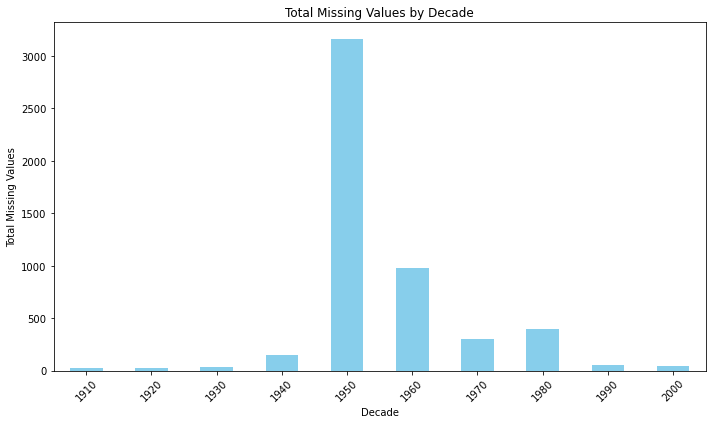

sample_date            0
station_id             0
latitude               0
longitude              0
conductance          736
dissolvedcalcium    1417
dissolvedsodium     1408
totalalkalinity      677
lab_ph               928
dtype: int64


In [56]:
#replace empty fields with null
merged_df['lab_ph'] = merged_df['lab_ph'].replace('', float('nan'))
#convert to numeric datatype
merged_df['lab_ph'] = pd.to_numeric(merged_df['lab_ph'], errors='coerce')

null_values_count = merged_df.isnull().sum()

merged_df['sample_date'] = pd.to_datetime(merged_df['sample_date'])

merged_df['decade'] = (merged_df['sample_date'].dt.year // 10) * 10

# Group by decade and calculate total missing values per column
missing_values_by_decade = merged_df.groupby('decade').apply(lambda x: x.isnull().sum().sum())

# Plot the total missing values by decade
plt.figure(figsize=(10, 6))
missing_values_by_decade.plot(kind='bar', color='skyblue')
plt.title('Total Missing Values by Decade')
plt.xlabel('Decade')
plt.ylabel('Total Missing Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(null_values_count)

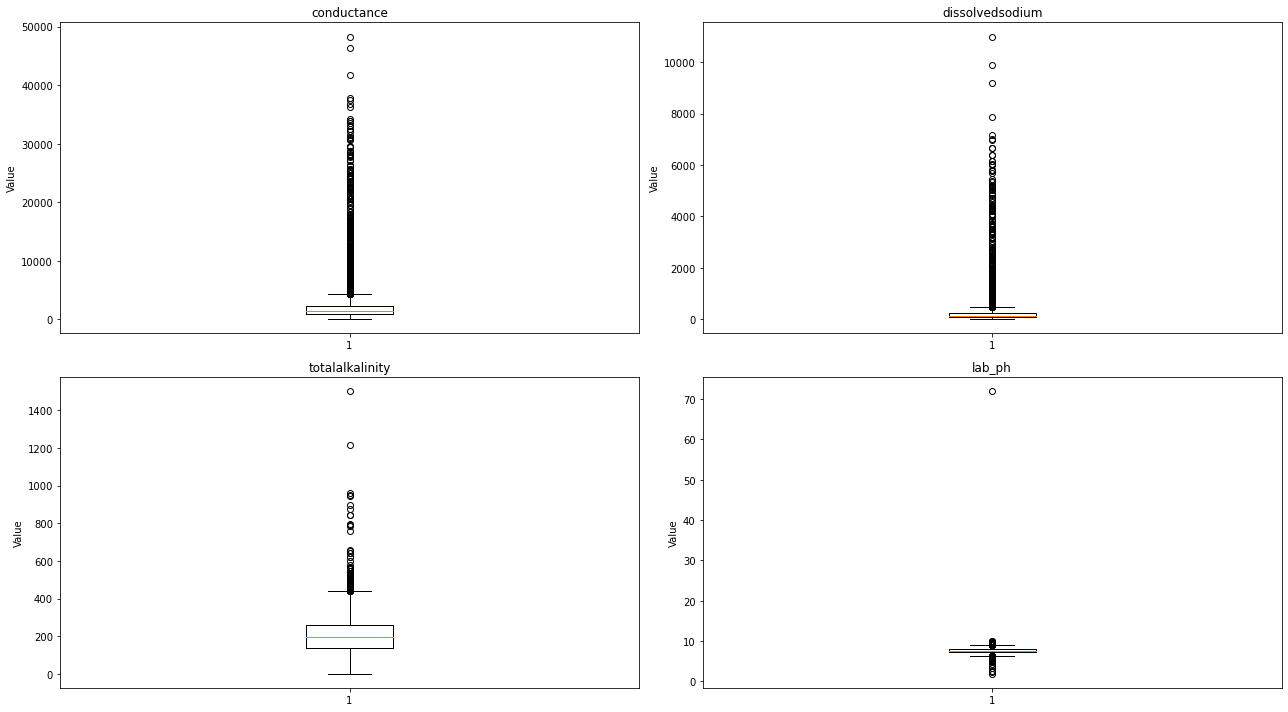

In [58]:
# List of columns for the boxplot
columns = ['conductance','dissolvedsodium', 'totalalkalinity', 'lab_ph']

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Flatten the 2x3 grid of subplots into a 1D array for easy iteration
axs = axs.flatten()

# Iterate over each column and create a boxplot in a separate subplot
for i, column in enumerate(columns):
    axs[i].boxplot(merged_df_filtered[column].dropna())
    axs[i].set_title(column)
    axs[i].set_ylabel('Value')

# Adjust the layout of subplots
plt.tight_layout()
plt.show()


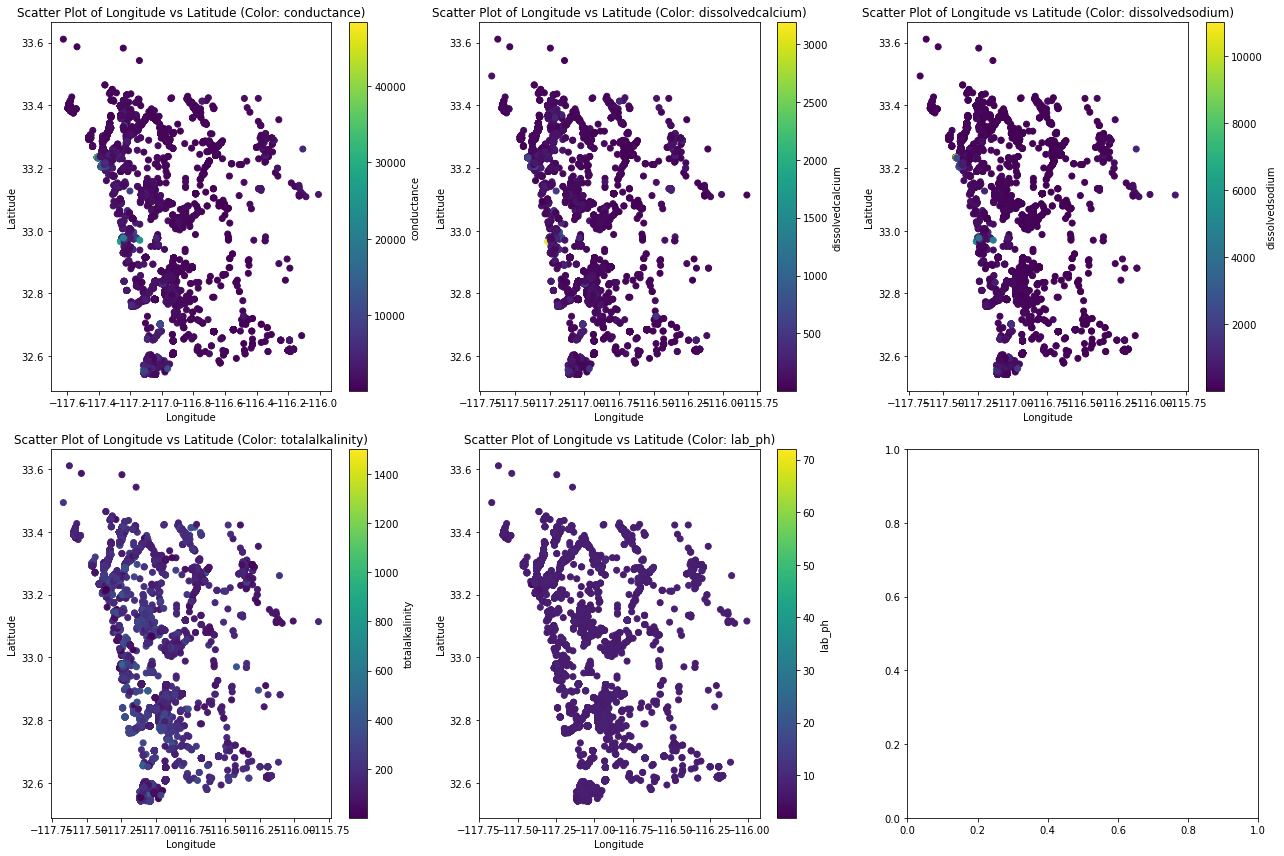

In [59]:
#there was a random datapoint out of san diego county
merged_df_filtered = merged_df_filtered[merged_df_filtered['latitude'] <= 34]
columns = ['conductance', 'dissolvedcalcium', 'dissolvedsodium', 'totalalkalinity', 'lab_ph']

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Flatten the axs array to iterate over it
axs = axs.flatten()

# Iterate over the columns and plot a scatter plot in each subplot
for i, col in enumerate(columns):
    # Create a scatter plot
    scatter = axs[i].scatter(merged_df_filtered['longitude'], merged_df_filtered['latitude'], c=merged_df_filtered[col], cmap='viridis')

    # Add colorbar
    plt.colorbar(scatter, ax=axs[i], label=col)

    # Add labels and title
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')
    axs[i].set_title(f'Scatter Plot of Longitude vs Latitude (Color: {col})')

# Adjust layout
plt.tight_layout()
plt.show()


**Correlation Matrix**

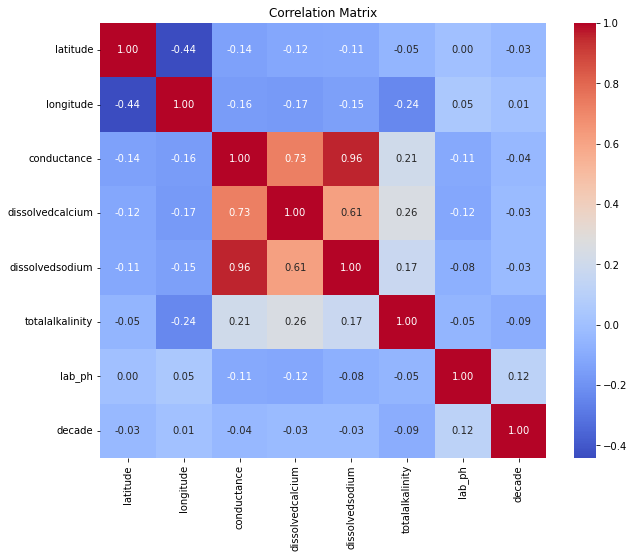

In [60]:
corr_matrix = merged_df_filtered.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

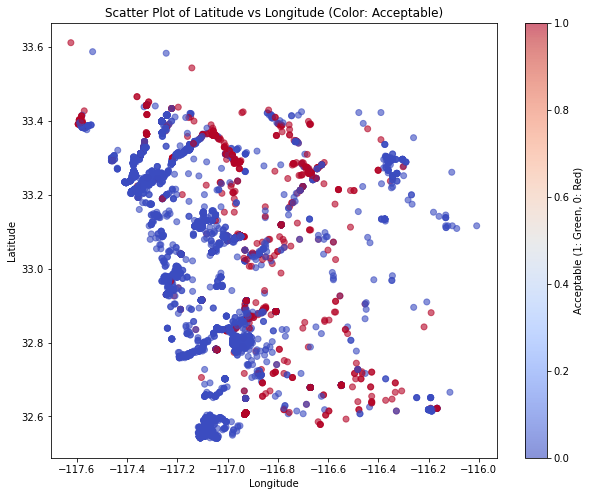

In [67]:
# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(merged_df_filtered['longitude'], merged_df_filtered['latitude'], 
                      c=merged_df_filtered['acceptable'], cmap='coolwarm', alpha=0.6)

# Add a colorbar
plt.colorbar(scatter, label='Acceptable (1: Green, 0: Red)')

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Latitude vs Longitude (Color: Acceptable)')

# Show plot
plt.show()


In [61]:
len(merged_df_filtered)

7908

## Drop any fields containing null values

In [63]:
merged_df_filtered = merged_df_filtered.dropna()

In [64]:
merged_df_filtered.head()

,sample_date,station_id,latitude,longitude,conductance,dissolvedcalcium,dissolvedsodium,totalalkalinity,lab_ph,decade
111,1947-10-10 00:00:00,5766,32.9128,-116.9256,520.0,22.0,68.0,131.0,8.1,1940
170,1949-10-21 12:00:00,5741,33.3370,-117.1356,526.0,39.0,56.0,159.0,8.3,1940
173,1949-12-06 00:00:00,26456,33.2956,-117.3509,950.0,62.0,116.0,220.0,7.4,1940
174,1949-12-22 00:00:00,27915,33.2186,-117.3409,1210.0,88.0,113.0,247.0,7.7,1940
175,1949-12-23 11:30:00,28000,33.2112,-117.3568,1400.0,100.0,136.0,231.0,7.8,1940


## Generate Target Variable, Specify Acceptable Ranges

Classify Water Quality into Acceptable and Unacceptable. Acceptable means requiring less processing for drinking. Unacceptable means requiring more processing for drinking

In [66]:
#conductance: 50-800
#dissolvedsodium: 20-200
#totalalkalinity:100-300
#labpH:6.5 to 8.5
cond_conductance = (merged_df_filtered['conductance'] >= 50) & (merged_df_filtered['conductance'] <= 800)
cond_dissolvedsodium = (merged_df_filtered['dissolvedsodium'] >= 20) & (merged_df_filtered['dissolvedsodium'] <= 200)
cond_totalalkalinity = (merged_df_filtered['totalalkalinity'] >= 100) & (merged_df_filtered['totalalkalinity'] <= 300)
cond_dissolvedcalcium = (merged_df_filtered['dissolvedcalcium'] >= 0) & (merged_df_filtered['dissolvedcalcium'] <= 200) #double check this value
cond_ph = (merged_df_filtered['lab_ph'] >= 6.5) & (merged_df_filtered['lab_ph'] <= 8.5)

# Create the 'acceptable' column
merged_df_filtered['acceptable'] = np.where(cond_conductance & cond_dissolvedsodium & cond_totalalkalinity & cond_dissolvedcalcium, 1, 0)

# Display the updated dataframe
merged_df_filtered.head()

counts = merged_df_filtered['acceptable'].value_counts()
print(counts)

merged_df_filtered.head()

0    4642
1     995
Name: acceptable, dtype: int64


,sample_date,station_id,latitude,longitude,conductance,dissolvedcalcium,dissolvedsodium,totalalkalinity,lab_ph,decade,acceptable
111,1947-10-10 00:00:00,5766,32.9128,-116.9256,520.0,22.0,68.0,131.0,8.1,1940,1
170,1949-10-21 12:00:00,5741,33.3370,-117.1356,526.0,39.0,56.0,159.0,8.3,1940,1
173,1949-12-06 00:00:00,26456,33.2956,-117.3509,950.0,62.0,116.0,220.0,7.4,1940,0
174,1949-12-22 00:00:00,27915,33.2186,-117.3409,1210.0,88.0,113.0,247.0,7.7,1940,0
175,1949-12-23 11:30:00,28000,33.2112,-117.3568,1400.0,100.0,136.0,231.0,7.8,1940,0


## Subset Training and Testing Dataframes

In [68]:
# Extract features and target variable
X = merged_df_filtered[['latitude','longitude']]
y = merged_df_filtered[['acceptable']]  # Adjust column names as needed

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Modeling

## Logistic Regression

In [69]:

# Assuming X_train, X_val, X_test are your feature matrices
# Train logistic regression model on preprocessed data
model = LogisticRegression()
model.fit(X_train, y_train)

# Validate the model
val_preds = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)
val_mae = mean_absolute_error(y_val, val_preds)
val_mse = mean_squared_error(y_val, val_preds)
val_rmse = np.sqrt(val_mse)
val_recall = recall_score(y_val, val_preds)
tn, fp, fn, tp = confusion_matrix(y_val, val_preds).ravel()
val_specificity = tn / (tn + fp)

print("Validation Metrics:")
print("Accuracy:", val_accuracy)
print("Mean Absolute Error:", val_mae)
print("Mean Squared Error:", val_mse)
print("Root Mean Squared Error:", val_rmse)
print("Recall (Sensitivity):", val_recall)
print("Specificity:", val_specificity)

# Test the final model on the test set
test_preds = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)
test_mae = mean_absolute_error(y_test, test_preds)
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = np.sqrt(test_mse)
test_recall = recall_score(y_test, test_preds)
tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()
test_specificity = tn / (tn + fp)

print("\nTest Metrics:")
print("Accuracy:", test_accuracy)
print("Mean Absolute Error:", test_mae)
print("Mean Squared Error:", test_mse)
print("Root Mean Squared Error:", test_rmse)
print("Recall (Sensitivity):", test_recall)
print("Specificity:", test_specificity)

Validation Metrics:
Accuracy: 0.7819148936170213
Mean Absolute Error: 0.21808510638297873
Mean Squared Error: 0.21808510638297873
Root Mean Squared Error: 0.4669958312265525
Recall (Sensitivity): 0.009259259259259259
Specificity: 0.9649122807017544

Test Metrics:
Accuracy: 0.7836879432624113
Mean Absolute Error: 0.21631205673758866
Mean Squared Error: 0.21631205673758866
Root Mean Squared Error: 0.4650935999748746
Recall (Sensitivity): 0.036036036036036036
Specificity: 0.9668874172185431


## Random Forest

In [73]:

# Initialize Random Forest 
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier 
rf_classifier.fit(X_train, y_train)

# Evaluate the model on the validation set
val_preds = rf_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)
val_mae = mean_absolute_error(y_val, val_preds)
val_mse = mean_squared_error(y_val, val_preds)
val_rmse = mean_squared_error(y_val, val_preds, squared=False)
val_recall = recall_score(y_val, val_preds)  # Recall is the same as sensitivity in a binary classification problem
val_specificity = accuracy_score(y_val, val_preds, normalize=True, sample_weight=None)  # For binary classification, specificity can be calculated as accuracy

print("Validation Metrics:")
print("Accuracy:", val_accuracy)
print("Mean Absolute Error:", val_mae)
print("Mean Squared Error:", val_mse)
print("Root Mean Squared Error:", val_rmse)
print("Recall/Sensitivity:", val_recall)
print("Specificity:", val_specificity)

# Test the final model on the test set
test_preds = rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)
test_mae = mean_absolute_error(y_test, test_preds)
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)
test_recall = recall_score(y_test, test_preds)  # Recall is the same as sensitivity in a binary classification problem
test_specificity = accuracy_score(y_test, test_preds, normalize=True, sample_weight=None)  # For binary classification, specificity can be calculated as accuracy

print("\nTest Metrics:")
print("Accuracy:", test_accuracy)
print("Mean Absolute Error:", test_mae)
print("Mean Squared Error:", test_mse)
print("Root Mean Squared Error:", test_rmse)
print("Recall/Sensitivity:", test_recall)
print("Specificity:", test_specificity)

Validation Metrics:
Accuracy: 0.8812056737588653
Mean Absolute Error: 0.11879432624113476
Mean Squared Error: 0.11879432624113476
Root Mean Squared Error: 0.344665528071977
Recall/Sensitivity: 0.6574074074074074
Specificity: 0.8812056737588653

Test Metrics:
Accuracy: 0.9131205673758865
Mean Absolute Error: 0.08687943262411348
Mean Squared Error: 0.08687943262411348
Root Mean Squared Error: 0.29475317237328164
Recall/Sensitivity: 0.7027027027027027
Specificity: 0.9131205673758865


## k-Nearest Neighbor

In [75]:

# Train k-Nearest Neighbors model
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# Evaluate the model on the validation set
val_preds = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)
val_mae = mean_absolute_error(y_val, val_preds)
val_mse = mean_squared_error(y_val, val_preds)
val_rmse = mean_squared_error(y_val, val_preds, squared=False)
val_recall = recall_score(y_val, val_preds)  # Recall is the same as sensitivity in a binary classification problem
val_specificity = accuracy_score(y_val, val_preds, normalize=True, sample_weight=None)  # For binary classification, specificity can be calculated as accuracy

print("Validation Metrics:")
print("Accuracy:", val_accuracy)
print("Mean Absolute Error:", val_mae)
print("Mean Squared Error:", val_mse)
print("Root Mean Squared Error:", val_rmse)
print("Recall/Sensitivity:", val_recall)
print("Specificity:", val_specificity)

# Test the final model on the test set
test_preds = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)
test_mae = mean_absolute_error(y_test, test_preds)
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)
test_recall = recall_score(y_test, test_preds)  # Recall is the same as sensitivity in a binary classification problem
test_specificity = accuracy_score(y_test, test_preds, normalize=True, sample_weight=None)  # For binary classification, specificity can be calculated as accuracy

print("\nTest Metrics:")
print("Accuracy:", test_accuracy)
print("Mean Absolute Error:", test_mae)
print("Mean Squared Error:", test_mse)
print("Root Mean Squared Error:", test_rmse)
print("Recall/Sensitivity:", test_recall)
print("Specificity:", test_specificity)

Validation Metrics:
Accuracy: 0.8794326241134752
Mean Absolute Error: 0.12056737588652482
Mean Squared Error: 0.12056737588652482
Root Mean Squared Error: 0.3472281323374084
Recall/Sensitivity: 0.7037037037037037
Specificity: 0.8794326241134752

Test Metrics:
Accuracy: 0.8865248226950354
Mean Absolute Error: 0.11347517730496454
Mean Squared Error: 0.11347517730496454
Root Mean Squared Error: 0.33686076842660756
Recall/Sensitivity: 0.6576576576576577
Specificity: 0.8865248226950354


## Gradient Boosting

In [76]:

# Train Gradient Boosting model
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# Evaluate the model on the validation set
val_preds = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)
val_mae = mean_absolute_error(y_val, val_preds)
val_mse = mean_squared_error(y_val, val_preds)
val_rmse = mean_squared_error(y_val, val_preds, squared=False)
val_recall = recall_score(y_val, val_preds)  # Recall is the same as sensitivity in a binary classification problem
val_specificity = accuracy_score(y_val, val_preds, normalize=True, sample_weight=None)  # For binary classification, specificity can be calculated as accuracy

print("Validation Metrics:")
print("Accuracy:", val_accuracy)
print("Mean Absolute Error:", val_mae)
print("Mean Squared Error:", val_mse)
print("Root Mean Squared Error:", val_rmse)
print("Recall/Sensitivity:", val_recall)
print("Specificity:", val_specificity)

# Test the final model on the test set
test_preds = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)
test_mae = mean_absolute_error(y_test, test_preds)
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)
test_recall = recall_score(y_test, test_preds)  # Recall is the same as sensitivity in a binary classification problem
test_specificity = accuracy_score(y_test, test_preds, normalize=True, sample_weight=None)  # For binary classification, specificity can be calculated as accuracy

print("\nTest Metrics:")
print("Accuracy:", test_accuracy)
print("Mean Absolute Error:", test_mae)
print("Mean Squared Error:", test_mse)
print("Root Mean Squared Error:", test_rmse)
print("Recall/Sensitivity:", test_recall)
print("Specificity:", test_specificity)

Validation Metrics:
Accuracy: 0.8794326241134752
Mean Absolute Error: 0.12056737588652482
Mean Squared Error: 0.12056737588652482
Root Mean Squared Error: 0.3472281323374084
Recall/Sensitivity: 0.6851851851851852
Specificity: 0.8794326241134752

Test Metrics:
Accuracy: 0.9060283687943262
Mean Absolute Error: 0.09397163120567376
Mean Squared Error: 0.09397163120567376
Root Mean Squared Error: 0.3065479264416475
Recall/Sensitivity: 0.7207207207207207
Specificity: 0.9060283687943262


Yes, you can use clustering algorithms to find the cluster center that represents the highest density of acceptable points in your dataset. One commonly used clustering algorithm for this purpose is DBSCAN (Density-Based Spatial Clustering of Applications with Noise).

## DBSCAN

In [80]:

# Assuming df contains latitude, longitude, and acceptable columns
X = merged_df_filtered[['latitude', 'longitude']].values

# Apply DBSCAN
dbscan = DBSCAN(eps=0.01, min_samples=3)
labels = dbscan.fit_predict(X)

# Calculate silhouette score and Davies-Bouldin index
silhouette = silhouette_score(X, labels)
davies_bouldin = davies_bouldin_score(X, labels)

print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)

# Get unique labels (excluding noise points)
unique_labels = np.unique(labels[labels != -1])

# Calculate cluster centers and counts for 'acceptable' points in each cluster
cluster_centers = []
for label in unique_labels:
    cluster_points = X[(labels == label) & (merged_df_filtered['acceptable'] == 1)]
    if len(cluster_points) > 0:
        cluster_center = np.mean(cluster_points, axis=0)
        cluster_centers.append((label, cluster_center, len(cluster_points)))

# Sort cluster centers by the number of 'acceptable' points
cluster_centers.sort(key=lambda x: x[2], reverse=True)

# Get the top 10 cluster centers
top_10_cluster_centers = cluster_centers[:10]

# Print the top 10 cluster centers
for i, (label, center, count) in enumerate(top_10_cluster_centers, 1):
    print(f"Rank {i}: Cluster {label} - Center (Latitude, Longitude): {center} - Number of 'acceptable' points: {count}")

Silhouette Score: 0.3710630915268476
Davies-Bouldin Index: 1.3252493227096316
Rank 1: Cluster 4 - Center (Latitude, Longitude): [  33.08787129 -116.95470693] - Number of 'acceptable' points: 101
Rank 2: Cluster 39 - Center (Latitude, Longitude): [  32.60824923 -116.92943846] - Number of 'acceptable' points: 65
Rank 3: Cluster 143 - Center (Latitude, Longitude): [  32.8839 -116.8078] - Number of 'acceptable' points: 57
Rank 4: Cluster 11 - Center (Latitude, Longitude): [  33.36103902 -117.0519878 ] - Number of 'acceptable' points: 41
Rank 5: Cluster 88 - Center (Latitude, Longitude): [  33.44226389 -117.32249444] - Number of 'acceptable' points: 36
Rank 6: Cluster 125 - Center (Latitude, Longitude): [  33.1184 -116.7867] - Number of 'acceptable' points: 36
Rank 7: Cluster 58 - Center (Latitude, Longitude): [  33.29552353 -116.97602059] - Number of 'acceptable' points: 34
Rank 8: Cluster 38 - Center (Latitude, Longitude): [  32.78102581 -117.04389355] - Number of 'acceptable' points: 31


<AxesSubplot:>

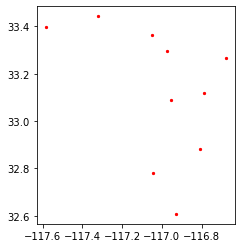

In [85]:
# Convert cluster centers to GeoDataFrame
geometry = [Point(center[1], center[0]) for label, center, count in top_10_cluster_centers]
gdf = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:4326')

# Plot the GeoDataFrame
gdf.plot(marker='o', color='red', markersize=5)


In [86]:
# Assuming df contains latitude, longitude, and acceptable columns
X = merged_df_filtered[['latitude', 'longitude']].values

# Apply DBSCAN
dbscan = DBSCAN(eps=0.01, min_samples=3)
labels = dbscan.fit_predict(X)

# Get unique labels (excluding noise points)
unique_labels = np.unique(labels[labels != -1])

# Calculate cluster centers and counts for 'acceptable' points in each cluster
cluster_centers = []
for label in unique_labels:
    cluster_points = X[(labels == label) & (merged_df_filtered['acceptable'] == 1)]
    if len(cluster_points) > 0:
        cluster_center = np.mean(cluster_points, axis=0)
        cluster_centers.append({'label': label, 'latitude': cluster_center[0], 'longitude': cluster_center[1], 'count': len(cluster_points)})

# Sort cluster centers by the number of 'acceptable' points
cluster_centers.sort(key=lambda x: x['count'], reverse=True)

# Get the top 10 cluster centers
top_10_cluster_centers = cluster_centers[:10]

# Initialize the map
mymap = folium.Map(location=[top_10_cluster_centers[0]['latitude'], top_10_cluster_centers[0]['longitude']], zoom_start=10)

# Add markers for cluster centers with labels
for center in top_10_cluster_centers:
    folium.Marker(
        location=[center['latitude'], center['longitude']],
        popup=f"Cluster: {center['label']}<br>Count: {center['count']}",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(mymap)



# Display the map
mymap
